### Dicionarios das variaveis

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pingouin as pg
from pingouin import pairwise_corr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pingouin as pg
import random 
import scipy.stats
from scipy import stats
import janitor

In [2]:
base_PAG_HEI = pd.read_csv('PAG_HEI.csv')
base_PHQ = pd.read_csv('DEMO_PHQ.csv')

### 1. Agrupamento dos bancos de dados

In [3]:
#VERIFICAÇÃO DOS VALORES DE CADA BASE E COLUNAS
#base_PAG_HEI.head()
#base_PHQ.head()

#base_PAG_HEI.columns
base_PHQ.columns

Index(['SEQN', 'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060',
       'DPQ070', 'DPQ080', 'DPQ090', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1',
       'DMDEDUC', 'INDFMINC'],
      dtype='object')

In [4]:
#VERIFICANDO TAMANHO DAS BASES
#base_PAG_HEI.shape
base_PHQ.shape

(5334, 15)

In [5]:
#CHECANDO SE EXISTEM LINHAS DUPLICADAS ANTES DE REALIZAR A JUNÇÃO DAS BASES
base_PAG_HEI.duplicated().sum()
base_PHQ.duplicated().sum()

0

In [6]:
#JOIN DAS COLUNAS POR MÉTODO OUTER JOIN, PARA PEGAR AS COLUNAS ÚNICAS DAS DUAS BASES
base = base_PHQ.merge(base_PAG_HEI, on='SEQN', how='inner')
base.to_csv('base_agrupada_inner.csv')

###### O interessante dessa nova base é analisar a relação entre o índice de saúde mental e os hábitos saudáveis; assim, a junção que fez mais sentido é a "inner", ainda que desconsiderando algumas descrições da base do Patient Health Questionnaire, que é maior. Para o caso de análise de dados referentes apenas à base do PHQ essa pode ser utilizada invés dessa nova base, visto que tem dados relativos a um maior número de entrevistados. 

### 2. Inspeção da base de dados agrupada

In [7]:
base.shape

(5334, 31)

#### 2.1 Verificação e alteração dos tipos de dados nas colunas


In [8]:
#OBTENDO OS TIPOS DAS COLUNAS
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5334 entries, 0 to 5333
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SEQN                      5334 non-null   int64  
 1   DPQ010                    4836 non-null   float64
 2   DPQ020                    4836 non-null   float64
 3   DPQ030                    4836 non-null   float64
 4   DPQ040                    4836 non-null   float64
 5   DPQ050                    4836 non-null   float64
 6   DPQ060                    4836 non-null   float64
 7   DPQ070                    4836 non-null   float64
 8   DPQ080                    4836 non-null   float64
 9   DPQ090                    4836 non-null   float64
 10  RIAGENDR                  5334 non-null   int64  
 11  RIDAGEYR                  5334 non-null   int64  
 12  RIDRETH1                  5334 non-null   int64  
 13  DMDEDUC                   5334 non-null   int64  
 14  INDFMINC

In [9]:
for column in base.iloc[:, 1:10]:
    print(base[column].value_counts())

0.0    3850
1.0     673
2.0     180
3.0     124
9.0       9
Name: DPQ010, dtype: int64
0.0    3769
1.0     769
2.0     179
3.0     114
9.0       5
Name: DPQ020, dtype: int64
0.0    3152
1.0    1071
3.0     320
2.0     286
9.0       7
Name: DPQ030, dtype: int64
0.0    2429
1.0    1706
2.0     370
3.0     326
9.0       5
Name: DPQ040, dtype: int64
0.0    3813
1.0     691
3.0     168
2.0     160
9.0       4
Name: DPQ050, dtype: int64
0.0    4134
1.0     513
2.0      95
3.0      89
9.0       5
Name: DPQ060, dtype: int64
0.0    4070
1.0     545
2.0     118
3.0      99
9.0       4
Name: DPQ070, dtype: int64
0.0    4362
1.0     341
2.0      79
3.0      45
9.0       9
Name: DPQ080, dtype: int64
0.0    4667
1.0     122
2.0      32
3.0      13
9.0       2
Name: DPQ090, dtype: int64


In [10]:
'''AS COLUNAS DO PHQ TEM O VALOR EM FLOAT E SERÃO SOMADAS PARA OBTENÇÃO DO SCORE, NO ENTANTO, OS VALORES "7" E "9" SÃO REFERENTES ÀS PESSOAS QUE NÃO RESPONDERAM O QUESTIONÁRIO E, POR ISSO, DEVEM SER DESCONSIDERADOS. VERIFICO O NÚMERO DE "7" E "9" E ALTERO PARA O VALOR MEDIANO DA COLUNA INSPECIONADA, VISANDO NÃO CRIAR UMA GRANDE ALTERAÇÃO NA SOMATÓRIA DOS PONTOS DO QUESTIONÁRIO, QUE SERÁ OBTIDA FUTURAMENTE NESSE CÓDIGO.
NÃO HÁ NENHUM NÚMERO "7" E OS "9" SÃO POUCOS NÚMEROS, ENTÃO A ALTERAÇÃO NÃO DEVE MODIFICAR MUITO A LEITURA DA BASE'''
#base.info()

for column in base.iloc[:, 1:10]:
#    print(base[column].value_counts())
    base[column].replace(9.0, base[column].median(), inplace=True)

In [11]:
#ALGUMAS VARIÁVEIS CATEGÓRICAS ESTÃO COMO TIPO FLOAT. ALTERO PARA 'CATEGORY' PARA FACILITAR A ANÁLISE
for column in ['RIAGENDR', 'RIDRETH1', 'DMDEDUC', 'INDFMINC', 'ADHERENCE']:
#    print(base[column].value_counts())
    base[column] = base[column].astype('category')

base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5334 entries, 0 to 5333
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   SEQN                      5334 non-null   int64   
 1   DPQ010                    4836 non-null   float64 
 2   DPQ020                    4836 non-null   float64 
 3   DPQ030                    4836 non-null   float64 
 4   DPQ040                    4836 non-null   float64 
 5   DPQ050                    4836 non-null   float64 
 6   DPQ060                    4836 non-null   float64 
 7   DPQ070                    4836 non-null   float64 
 8   DPQ080                    4836 non-null   float64 
 9   DPQ090                    4836 non-null   float64 
 10  RIAGENDR                  5334 non-null   category
 11  RIDAGEYR                  5334 non-null   int64   
 12  RIDRETH1                  5334 non-null   category
 13  DMDEDUC                   5334 non-null   catego

In [12]:
#FALTA, AINDA, CHECAR SE NÃO EXISTEM VALORES ESTRANHOS NOS SCORES DO HEI, NESSE CASO, VERIFICO OS NÚMEROS MÍNIMOS E MÁXIMOS PARA SABER SE NÃO EXISTE NENHUM NÚMERO ESTRANHO ÀS BASES

for col in base.loc[:, 'HEI2015C1_TOTALVEG': 'HEI2015C13_ADDSUG']:
    min_ = base[col].min()
    max_ = base[col].max()
    print(f'Na coluna {base[col].name} o valor mínimo é {min_} e o valor máximo é {max_}')


Na coluna HEI2015C1_TOTALVEG o valor mínimo é 0.0 e o valor máximo é 5.0
Na coluna HEI2015C2_GREEN_AND_BEAN o valor mínimo é 0.0 e o valor máximo é 5.0
Na coluna HEI2015C3_TOTALFRUIT o valor mínimo é 0.0 e o valor máximo é 5.0
Na coluna HEI2015C4_WHOLEFRUIT o valor mínimo é 0.0 e o valor máximo é 5.0
Na coluna HEI2015C5_WHOLEGRAIN o valor mínimo é 0.0 e o valor máximo é 5.0
Na coluna HEI2015C6_TOTALDAIRY o valor mínimo é 0.0 e o valor máximo é 5.0
Na coluna HEI2015C7_TOTPROT o valor mínimo é 0.0 e o valor máximo é 5.0
Na coluna HEI2015C8_SEAPLANT_PROT o valor mínimo é 0.0 e o valor máximo é 5.0
Na coluna HEI2015C9_FATTYACID o valor mínimo é 0.0 e o valor máximo é 10.0
Na coluna HEI2015C10_SODIUM o valor mínimo é 0.0 e o valor máximo é 10.0
Na coluna HEI2015C11_REFINEDGRAIN o valor mínimo é 0.0 e o valor máximo é 10.0
Na coluna HEI2015C12_SFAT o valor mínimo é 0.0 e o valor máximo é 10.0
Na coluna HEI2015C13_ADDSUG o valor mínimo é 0.0 e o valor máximo é 10.0


######  Há duas inconsistências aqui. As colunas de grãos integrais (WHOLEGRAIN) e LATICÍNIOS (TOTALDAIRY) vão de 0 a 10 segundo a documentação, mas na base os valores vão de 0-5. Pela exatidão dos valores imagino que há problemas na documentação.

#### 2.2 Tratamento de valores nulos

In [13]:
#ENCONTRANDO OS VALORES NULOS DA BASE
#base.isnull().sum()
base.dropna(axis=0, subset='DPQ010', inplace=True)

###### Como a base de saúde mental é maior do que as outras, existem 498 valores nulos em cada uma das colunas importadas do PHQ, referentes às entradas que não tem sequência numérica encontrada na base de nutrição e esportes. Como a análise é principalmente referente à relação entre essas duas colunas, removi as linhas sem valores para a base de hábitos saudáveis. 

In [14]:
#COM OS VALORES NULOS REFERENTES AO PHQ REMOVIDOS, É HORA DE TRATAR OS NULOS DAS BASES DE HÁBITOS SAUDÁVEIS. PARA O CASO DA VARIÁVEL CATEGÓRICA O PREENCHIMENTO É FEITO COM A MODA, ISSO É, A CATEGORIA QUE APARECE MAIS. NO CASO DOS DADOS NUMÉRICOS É NECESSÁRIO, PRIMEIRO, VERIFICAR A DISTRIBUIÇÃO DOS DADOS, CASO AS DISTRIBUIÇÕES SEJAM NORMAIS, SERÁ ADOTADO A MÉDIA PARA PREECHIMENTO DOS DADOS FALTANTES, CASO A DISTRIBUIÇÃO SEJA DESIGUAL OS DADOS SERÃO TRATADOS COM A UTILIZAÇÃO DA MEDIANA.

lista_histogramas = [base[col].name for col in base.columns if base[col].name[0:7] == 'HEI2015'] 

def plot_histogramas(lista):
    figure, axes = plt.subplots(2, round(len(lista_histogramas)/2), figsize=(25,10), facecolor='white')

    x, y = 0, 0
    for col in lista:
        axes[x, y].hist(x=base[col], color='#C3C49E')
        axes[x, y].axvline(base[col].mean(), color='#524632')
        axes[x, y].axvline(base[col].median(), color='red', linestyle='--')
        axes[x, y].set_xlabel(col)
        axes[x, y].xaxis.set_label_position('top')
        if x == y == 0:
            x += 1
        elif x == 1:
            y += 1
            x = 0
        elif x == 0:
            x += 1

    figure.suptitle('Figura 1 - Histogramas de distribuição das variáveis na base', fontsize=16)

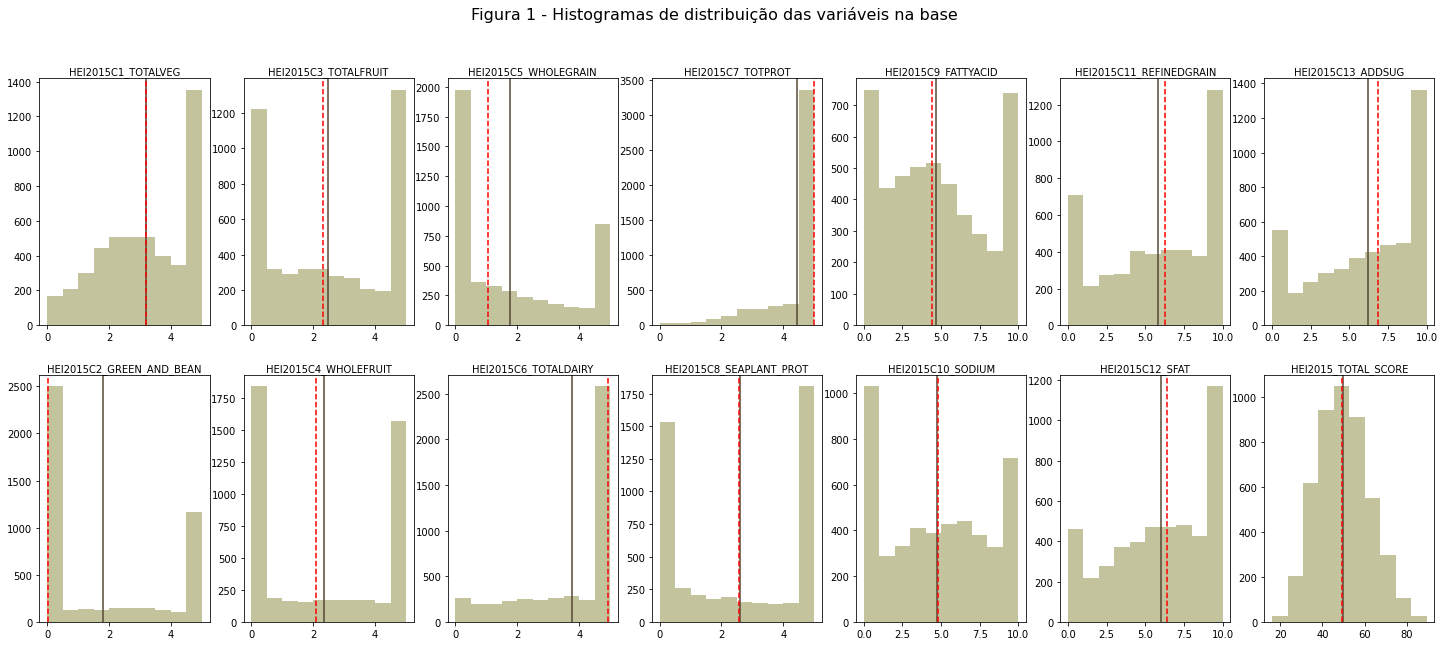

In [15]:
plot_histogramas(lista_histogramas)

In [16]:
#COMO EM TODOS OS CASOS A MÉDIA E A MEDIANA NÃO ESTIVERAM MUITO DISPERSAS, PREENCHO TODAS AS VARIÁVEIS NUMÉRICAS COM SUAS MÉDIAS
moda_indfminc = base['INDFMINC'].mode()

base.loc[:, 'INDFMINC'].fillna(11.0, inplace=True)
[base[col].fillna(base[col].mean(), inplace=True) for col in lista_histogramas]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### 3. Criação de colunas adicionais para análise

In [17]:
#CRIAÇÃO DE UMA COLUNA QUE SOMA O TOTAL DO VALOR DE SAÚDE MENTAL DOS PACIENTES A PARTIR DAS RESPOSTAS DO PHQ
base['phq9_score'] = base.loc[:,'DPQ010':'DPQ090'].sum(1)

In [18]:
#COLUNA QUE CATEGORIZA A CONDIÇÃO DE SAÚDE MENTAL DO PACIENTE A PARTIR DO SOMATÓRIO DAS RESPOSTAS
condicoes = [
        (base['phq9_score'] < 5),
        (base['phq9_score'] >= 5) & (base['phq9_score'] < 10),
        (base['phq9_score'] >= 10) & (base['phq9_score'] < 15),
        (base['phq9_score'] >= 15) & (base['phq9_score'] < 19),
        (base['phq9_score'] >= 19)
        ]

valores = ['0', '1', '2', '3', '4']

base['phq_grp'] = np.select(condicoes, valores)
base.to_csv('base_corrigida.csv')

### 4. Análise exploratória dos dados

In [19]:
base.columns

Index(['SEQN', 'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060',
       'DPQ070', 'DPQ080', 'DPQ090', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1',
       'DMDEDUC', 'INDFMINC', 'PAG_MINW', 'ADHERENCE', 'HEI2015C1_TOTALVEG',
       'HEI2015C2_GREEN_AND_BEAN', 'HEI2015C3_TOTALFRUIT',
       'HEI2015C4_WHOLEFRUIT', 'HEI2015C5_WHOLEGRAIN', 'HEI2015C6_TOTALDAIRY',
       'HEI2015C7_TOTPROT', 'HEI2015C8_SEAPLANT_PROT', 'HEI2015C9_FATTYACID',
       'HEI2015C10_SODIUM', 'HEI2015C11_REFINEDGRAIN', 'HEI2015C12_SFAT',
       'HEI2015C13_ADDSUG', 'HEI2015_TOTAL_SCORE', 'phq9_score', 'phq_grp'],
      dtype='object')

In [145]:
teste = base.groupby('RIAGENDR')['phq_grp'].value_counts()
#print(teste)

(0.0, 6000.0)

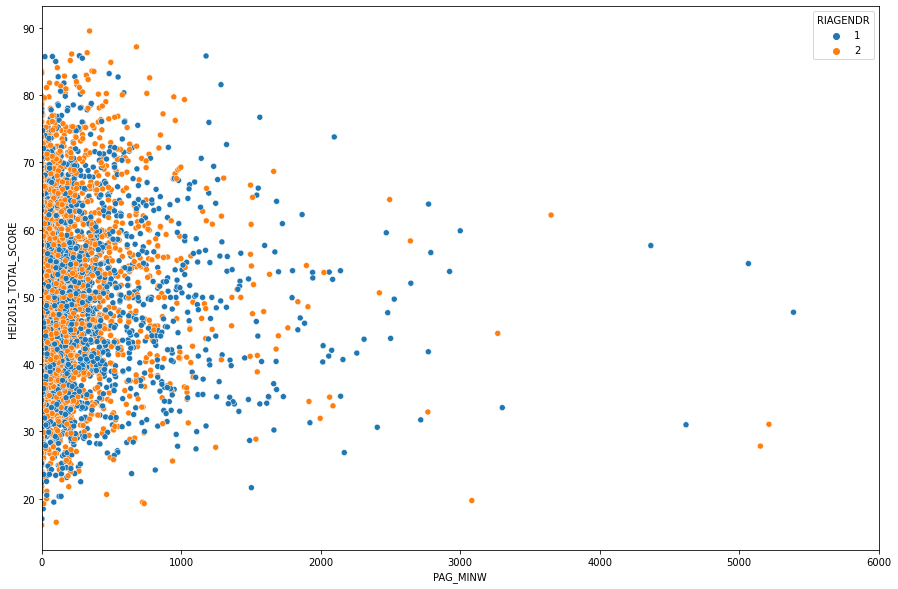

In [86]:
fig, axes = plt.subplots(figsize=(15,10))
bp = sns.scatterplot(x=(base['PAG_MINW'])/2, y=base['HEI2015_TOTAL_SCORE'], hue=base['RIAGENDR'])
axes.set_xlim([0,6000])

<AxesSubplot:xlabel='phq_grp', ylabel='count'>

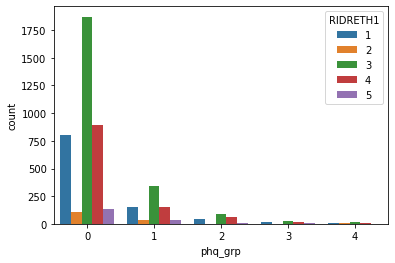

In [70]:
sns.countplot(base['phq_grp'], hue=base['RIDRETH1'])